# Aim: To simulate for 8 assets on the local by increasing the no of alphas , changing different classical optimisers COBYLA ,CG POWELL and trying to run it on qasm simulator, fake backends i.e. Fake Mumbai, Fake Torronto

In [128]:
from qiskit.algorithms.optimizers import COBYLA,CG,POWELL, GradientDescent
from qiskit.algorithms import NumPyMinimumEigensolver, VQE,QAOA
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit import execute, Aer
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [2]:
#maruti,ongc,tatasteel,hindalco,icici
mu5 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464])#maruti,ongc,tatasteel,hindalco,icici

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro
mu8 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724])

#maruti,ongc,tatasteel,hindalco,icici,britannia,ultra,wipro,apollo,jublfoods
mu10 = np.array([-0.01278393459,-0.01757157357,0.00153724791,-0.015034464,-0.015034464,-0.01387133952,-0.01447346195,
                -0.01674339724,-0.0132387857,-0.01195091376])

sigma5 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.0156661810]
        
    ]
)


sigma8 =  np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546,0.0156690731,0.01550048831,0.01547100286],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576]
    ]
)

sigma10 = np.array(
    [
        [0.0157149876, 0.01543639416,0.01557457106, 0.01548754824, 0.01551981118,0.01552742087,0.01551068247,0.01549833146,0.01555422578,0.01560541445],
        [0.01543639416,0.01626383626, 0.01518401219, 0.01572622731, 0.01547586679, 0.01523653022,0.01540274745,0.01539792764,0.01529484431,0.01522477939],
        [0.01557457106, 0.01518401219, 0.03221621237,0.01521450154, 0.01560453568, 0.01568907088,0.01536051938,0.01517390478,0.01544208176,0.01533647982],
        [0.01548754824, 0.01572622731,0.01521450154, 0.01609035237, 0.01563323403, 0.01546962982,0.01556278296,0.01563908817,0.01556359729,0.01560570359],
        [0.01551981118, 0.01547586679,0.01560453568, 0.01563323403, 0.01566618101, 0.01551780546,0.01554861694,0.01554772412,0.01554744909,0.01561664097],
        [0.01552742087,0.01523653022, 0.01568907088, 0.01546962982, 0.01551780546, 0.0156690731,0.01550048831,0.01547100286,0.01552910437,0.0155765202],
        [0.01551068247,0.01540274745,0.01536051938,0.01556278296,0.01554861694,0.01550048831,0.01570878379,0.01551585945,0.01551281895,0.01563468601],
        [0.01549833146,0.01539792764,0.01517390478,0.01563908817,0.01554772412,0.01547100286,0.01551585945,0.01568793576,0.0155514752,0.01569287103],
        [0.01555422578,0.01529484431,0.01544208176,0.01556359729,0.01554744909,0.01552910437,0.01551281895,0.0155514752,0.0157783728,0.01565209048],
        [0.01560541445,0.01522477939,0.01533647982,0.01560570359,0.01561664097,0.0155765202,0.01563468601,0.01569287103,0.01565209048,0.0161425637]
    ]
)

In [3]:
# prepare problem instance
n = 8  # number of assets
q = 0.5  # risk factor
budget = n // 2  # budget
penalty = 2 * n  # scaling of penalty term

Creating a quadratic problem

In [4]:
# create docplex model
mdl = Model("portfolio_optimization")
x = mdl.binary_var_list(range(n), name="x")
objective = mdl.sum([mu8[i] * x[i] for i in range(n)])
objective -= q * mdl.sum([sigma10[i, j] * x[i] * x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to
qp = from_docplex_mp(mdl)

Solving the problem classically

In [5]:
%%time
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(opt_result.prettyprint())

objective function value: -0.17240876954999998
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS
CPU times: total: 109 ms
Wall time: 128 ms


Using a linear equality to penalty converter on the quadratic problem so that the constraints are taken into account in the objective, making the problem simpler. Converting to an ising model after that

In [6]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

1-Using cobyla optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [7]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [98]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

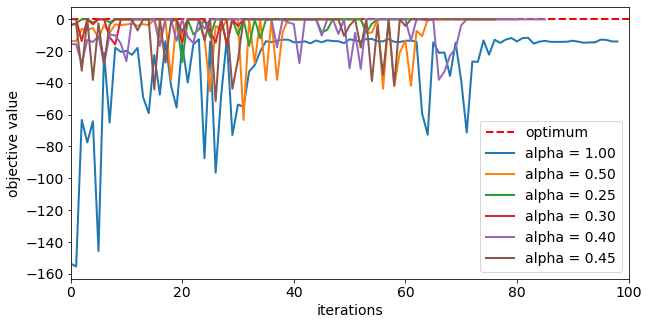

In [99]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [100]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [101]:
from qiskit import transpile

In [102]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [103]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

#Cost is described as following in the into notebook for a maxcut problem #task_price = 0.25 # price for submitting task to system (in dollars)

#price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars)

#price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars)

#price_per_Xrot = 0.00008 # price for a single X rotation (in dollars)

#price_per_shot = p (len(G.edges()) (2 price_per_CNOT + price_per_Zrot) + len(G.nodes()) price_per_Xrot)

#optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.

#Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware. Cost = (Optim_evals shotsin price_per_shot) + task_price

We decided to define our cost in a similar way below. We calculate the cost for different alpha values seperately as the number of iterations required for convergence is different for different alpha values. The default number of shots is 1024. We just set cost of a single cx gate as 0.0001and the cost of a single qubit gate as 0.00005. Task price is 0.25.

In [104]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 831.5332000000001
Total cost for when alpha is 0.5: 680.3908
Total cost for when alpha is 0.25: 520.8516000000001
Total cost for when alpha is 0.3: 268.9476
Total cost for when alpha is 0.4: 722.3748
Total cost for when alpha is 0.45: 646.8036000000001


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [105]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Circuit depth

In [20]:
qc_basis.depth()

42

Optimizer time

In [106]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 44.52864956855774
Optimizer time for alpha 0.5: 37.805917501449585
Optimizer time for alpha 0.25: 27.85313320159912
Optimizer time for alpha 0.3: 12.644086122512817
Optimizer time for alpha 0.4: 35.68240189552307
Optimizer time for alpha 0.45: 33.75796937942505


Note: alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

Trying different fake backends and using noise models for the same experiment

The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

1- FakeMumbai backend

In [22]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.utils import QuantumInstance

In [23]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [24]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

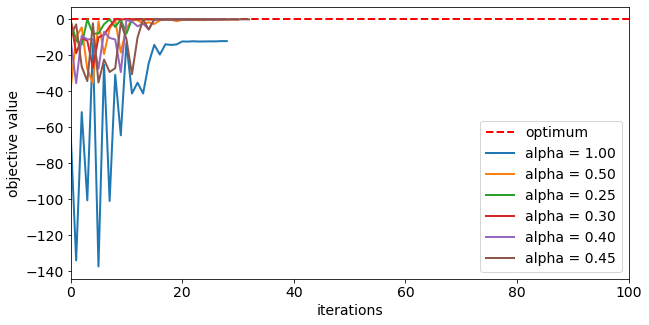

In [25]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [26]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 105), ('u', 82)])

In [27]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 433.81160000000006
Total cost for when alpha is 0.5: 463.71240000000006
Total cost for when alpha is 0.25: 418.86120000000005
Total cost for when alpha is 0.3: 403.91080000000005
Total cost for when alpha is 0.4: 463.71240000000006
Total cost for when alpha is 0.45: 493.61320000000006


In [28]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


In [29]:
### Circuit depth ###

qc_basis.depth()

78

In [30]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 36.08662152290344
Optimizer time for alpha 0.5: 37.85476756095886
Optimizer time for alpha 0.25: 34.509817600250244
Optimizer time for alpha 0.3: 33.195634603500366
Optimizer time for alpha 0.4: 37.61702108383179
Optimizer time for alpha 0.45: 45.44560670852661


Note: alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

2-FakeToronto device backend

In [31]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [107]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

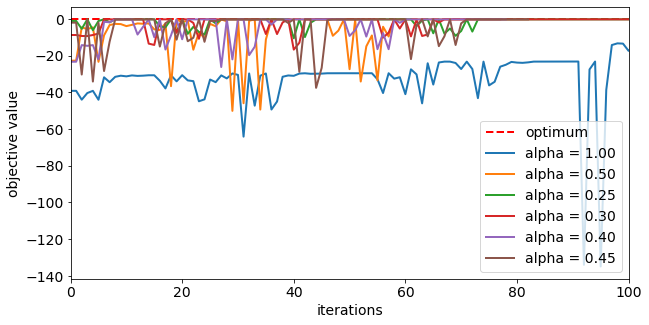

In [108]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [109]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 115), ('u', 82)])

In [110]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 4808.5444
Total cost for when alpha is 0.5: 1246.2531999999999
Total cost for when alpha is 0.25: 1805.3572
Total cost for when alpha is 0.3: 1757.434
Total cost for when alpha is 0.4: 1262.2276
Total cost for when alpha is 0.45: 1326.1252


In [111]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Note: alpha=0.4 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.3,alpha 1,alpha 0.25 ,alpha 0.45.This is because alpha=0.4 led to convergence much faster.

Using 'CG' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [37]:
# set classical optimizer
maxiter = 100
optimizer = CG(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [112]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

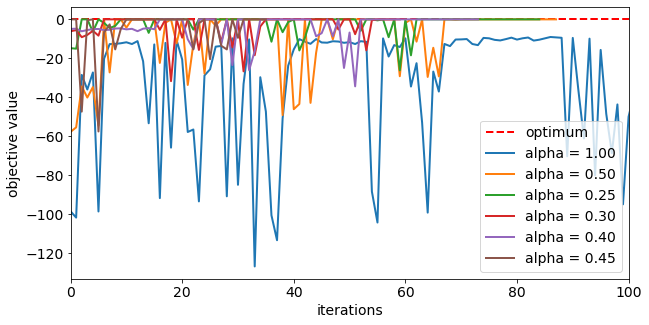

In [113]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [114]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [115]:
from qiskit import transpile

In [116]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [117]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

In [118]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 1125.4212
Total cost for when alpha is 0.5: 739.1684
Total cost for when alpha is 0.25: 713.9780000000001
Total cost for when alpha is 0.3: 504.05800000000005
Total cost for when alpha is 0.4: 621.6132
Total cost for when alpha is 0.45: 302.5348


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [45]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.1729605453299996
The optimal value with alpha 0.45: -0.17240876954997475


Circuit depth

In [46]:
qc_basis.depth()

42

Optimizer time

In [47]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 34.8460111618042
Optimizer time for alpha 0.5: 30.844340085983276
Optimizer time for alpha 0.25: 28.909526586532593
Optimizer time for alpha 0.3: 30.92631769180298
Optimizer time for alpha 0.4: 46.258105993270874
Optimizer time for alpha 0.45: 32.95039343833923


Note: alpha=0.45 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.3,alpha 1,alpha 0.4 ,alpha 0.25.This is because alpha=0.45 led to convergence much faster.

Trying different fake backends and using noise models for the same experiment

The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

1- FakeMumbai backend

In [48]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

In [49]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [119]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

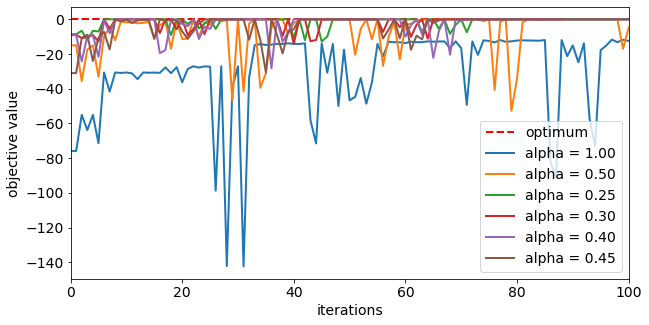

In [120]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [121]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 115), ('u', 70)])

In [122]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 3932.41
Total cost for when alpha is 0.5: 1966.33
Total cost for when alpha is 0.25: 1659.1299999999999
Total cost for when alpha is 0.3: 1367.29
Total cost for when alpha is 0.4: 1981.6899999999998
Total cost for when alpha is 0.45: 2166.0099999999998


In [93]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


In [55]:
### Circuit depth ###

qc_basis.depth()

97

In [56]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 3.411324977874756
Optimizer time for alpha 0.5: 3.15185809135437
Optimizer time for alpha 0.25: 3.397707462310791
Optimizer time for alpha 0.3: 3.1480350494384766
Optimizer time for alpha 0.4: 3.3973288536071777
Optimizer time for alpha 0.45: 3.45501446723938


Note: Note: alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

​

2-FakeToronto device backend

In [57]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [123]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

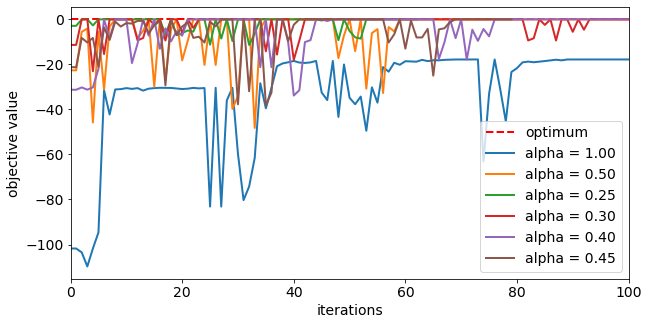

In [124]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [125]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 89), ('u', 88)])

In [126]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 3936.1987999999997
Total cost for when alpha is 0.5: 1797.9843999999998
Total cost for when alpha is 0.25: 858.2596
Total cost for when alpha is 0.3: 1498.3619999999999
Total cost for when alpha is 0.4: 1716.2692
Total cost for when alpha is 0.45: 1089.786


In [127]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Note: alpha=0.25 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.4,alpha 1,alpha 0.3 ,alpha 0.45.This is because alpha=0.25 led to convergence much faster.Note: 

Using 'POWELL' optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values

In [62]:
# set classical optimizer
maxiter = 100
optimizer = POWELL(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25,0.30,0.40,0.45]  # confidence levels to be evaluated

Fitting CVaR QAOA

In [63]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

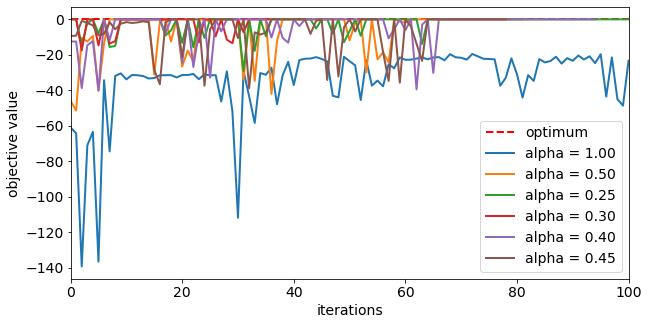

In [64]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [65]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 8), ('PauliEvolution', 2)])

In [66]:
from qiskit import transpile

In [67]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [68]:
gate_dict

OrderedDict([('cx', 56), ('u', 52)])

Finding the circuit cost

In [69]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 2662.0356
Total cost for when alpha is 0.5: 688.7876000000001
Total cost for when alpha is 0.25: 848.3268
Total cost for when alpha is 0.3: 310.9316
Total cost for when alpha is 0.4: 797.946
Total cost for when alpha is 0.45: 663.5972


We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here.

In [70]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Circuit depth

In [71]:
qc_basis.depth()

42

Optimizer time

In [72]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 147.79135394096375
Optimizer time for alpha 0.5: 34.20756769180298
Optimizer time for alpha 0.25: 45.393500089645386
Optimizer time for alpha 0.3: 14.41401720046997
Optimizer time for alpha 0.4: 41.71681332588196
Optimizer time for alpha 0.45: 34.89099621772766


Note: alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

Trying different fake backends and using noise models for the same experiment

1- FakeMumbai backend

In [73]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

In [74]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [89]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

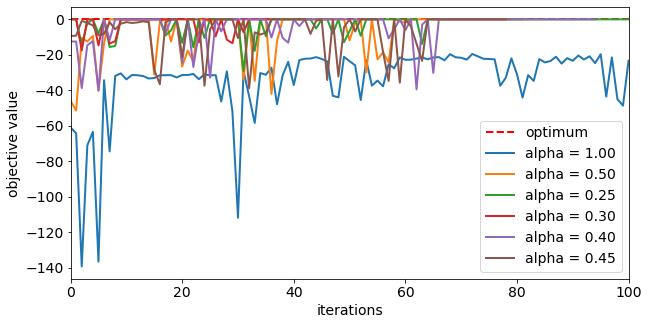

In [75]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [76]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 117), ('u', 76)])

In [77]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 5031.674
Total cost for when alpha is 0.5: 1301.754
Total cost for when alpha is 0.25: 1603.322
Total cost for when alpha is 0.3: 587.514
Total cost for when alpha is 0.4: 1508.09
Total cost for when alpha is 0.45: 1254.138


In [78]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


In [79]:
### Circuit depth ###

qc_basis.depth()

96

In [80]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 147.79135394096375
Optimizer time for alpha 0.5: 34.20756769180298
Optimizer time for alpha 0.25: 45.393500089645386
Optimizer time for alpha 0.3: 14.41401720046997
Optimizer time for alpha 0.4: 41.71681332588196
Optimizer time for alpha 0.45: 34.89099621772766


Note: alpha=0.3 seems best due to slightly lower cost and the optimal values of the alphas are different

2-FakeToronto device backend

In [81]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['cx', 'id', 'measure', 'x', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [82]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.17240876954997475
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0
status: SUCCESS

CPU time

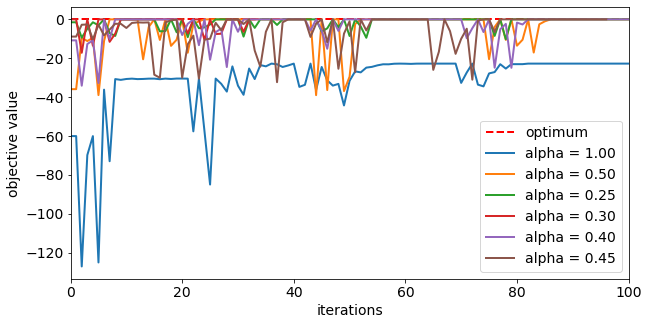

In [83]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [84]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 101), ('u', 100)])

In [85]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 1778.4260000000004
Total cost for when alpha is 0.5: 1592.8772000000004
Total cost for when alpha is 0.25: 1592.8772000000004
Total cost for when alpha is 0.3: 525.9716000000001
Total cost for when alpha is 0.4: 1809.3508000000002
Total cost for when alpha is 0.45: 1500.1028000000001


In [86]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.17240876954997475
The optimal value with alpha 0.5: -0.17240876954997475
The optimal value with alpha 0.25: -0.17240876954997475
The optimal value with alpha 0.3: -0.17240876954997475
The optimal value with alpha 0.4: -0.17240876954997475
The optimal value with alpha 0.45: -0.17240876954997475


Note : alpha=0.3 seems best due to slightly lower cost and the same optimal value as alpha 0.5,alpha 0.25,alpha 1,alpha 0.4 ,alpha 0.45.This is because alpha=0.3 led to convergence much faster.

### Conclusion : 1) As we concluded from our results running on IBM quantum cloud that Fake Backend Washington was a poor choice where it has large no of Qubits i.e.127 which is not require for our used cases.
### 2)Secondaly on IBM Quantum Cloud, Fake Mumbai And Fake Torronto backend was taking time approximately ~ 1 hour to print the required result but running it locally is taking comparatively less time.
### 3) For a particular case of Optimisers it is showing different alpha's cost when trying it on qasm simulator and different fake backends
Reason might be the error parameters and noise is a little more